In [72]:
import numpy as np
import os
import glob
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline


In [73]:
dict_class ={'Not Parkinsons':0, 'Parkinsons':1}

reverse_map = {v: k for k, v in dict_class.items()}
print(reverse_map)

{0: 'Not Parkinsons', 1: 'Parkinsons'}


In [74]:
#import spectrograms
spect = []
spect_id = []
park_id = []
#for j in ['Parkinsons','NonParkinsons']:

for q in ['alda','Bannister','Buck','Bush', 'Connolly','Isakson','JesseJackson','Kinsley',
             'MJF','Serrano','Shapiro']:
    file = []
    for root, dirs, files in os.walk('Specs/Parkinsons/'+q):
        file += glob.glob(os.path.join(root,'*.png'))
    for i in file:
        x = plt.imread(i) 
        spect.append(x)
        spect_id.append(q)
        park_id.append(1)       
for q in ['Bray','Crystal','Cummberbatch','Dispenza', 'Letterman','Phillips','Prevlen','Spurlock',
             'Treasure','Tyson','Urban','Walker']:
    file = [] 
    for root, dirs, files in os.walk('Specs/NonParkinsons/'+q):
        file += glob.glob(os.path.join(root,'*.png'))
    for i in file:
        x = plt.imread(i) 
        spect.append(x)
        spect_id.append(q)
        park_id.append(0)
    
x_train = spect
y_train = spect_id
YTrain = park_id


In [167]:
npzfile = np.load('all_data.npz')
print(npzfile.files)
X_data = npzfile['arr_0']
y_data = npzfile['arr_1']

['arr_0', 'arr_1']


In [175]:
#create subset of data for test and train
import random
print(len(X_data))
print(len(y_data))
test_indices = random.sample(range(len(X_data)), 630)
train_indices = []
for i in range(len(X_data)):
    if i not in test_indices:
        train_indices.append(i)

x_new_train = []
y_new_train = []
YNEWTRAIN = []
x_test = []
y_test = []
YTEST = []
print(test_indices,train_indices)
for i in test_indices:
    x_test.append(X_data[i])
    y_test.append(y_data[i])
    

for i in train_indices:
    x_new_train.append(X_data[i])
    y_new_train.append(y_data[i])
   

2105
2105
[2007, 1411, 1936, 1335, 76, 713, 1028, 1253, 1933, 891, 1485, 1430, 97, 1491, 1887, 1056, 1905, 972, 2083, 1859, 58, 1572, 1209, 204, 389, 138, 120, 952, 1121, 484, 1769, 1576, 301, 1533, 1758, 261, 1703, 798, 1051, 319, 1503, 344, 1886, 657, 1797, 1239, 180, 1583, 172, 1864, 91, 1573, 459, 245, 158, 1764, 1370, 1352, 1260, 1847, 1497, 1088, 67, 215, 916, 2024, 2030, 1380, 594, 110, 94, 6, 1871, 1225, 2079, 825, 661, 985, 557, 2018, 1425, 2019, 165, 1418, 1727, 491, 1392, 1857, 1850, 1820, 2008, 240, 1354, 804, 1204, 226, 479, 285, 478, 3, 1192, 1585, 1468, 1382, 571, 1954, 1254, 424, 300, 974, 569, 656, 1383, 441, 2012, 709, 1362, 465, 894, 1975, 1112, 1277, 288, 1555, 704, 1695, 1490, 697, 776, 1657, 1181, 1483, 1519, 1128, 116, 1247, 904, 721, 1927, 178, 200, 1990, 1571, 1228, 1869, 1732, 743, 1280, 1837, 1567, 297, 2100, 1710, 984, 2036, 1554, 1796, 827, 755, 1132, 314, 2104, 1046, 1565, 858, 1218, 1688, 385, 448, 1520, 1668, 523, 1863, 676, 362, 823, 1179, 83, 1236, 109

In [176]:
X_train = np.asarray(x_new_train)
Y_train = np.asarray(y_new_train)
X_valid = np.asarray(x_test)
Y_valid = np.asarray(y_test)

Y_train = keras.utils.np_utils.to_categorical(Y_train)
Y_valid = keras.utils.np_utils.to_categorical(Y_valid)

In [170]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2] 
n_time = X_train.shape[1]


In [171]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (4,4)
pool_size_1= (2,2) 
pool_size_2= (2,2)
pool_size_3 = (2,2)

dropout_prob = 0.20
dense_size1 = 216
lstm_count = 64
num_units = 128

BATCH_SIZE = 64
EPOCH_COUNT = 200
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5',input_shape=(288,432,4))(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    print(pool_lstm1)
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    #flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [172]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 216
    n_frames = 128
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    #input_shape = (n_frames, n_frequency,4)
    input_shape = (128, 216,1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.bestv3.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [173]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [177]:
model, history  = train_model(X_train, Y_train, X_valid, Y_valid)

Building model...
Tensor("pool_lstm_37/MaxPool:0", shape=(?, 64, 108, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 216, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 125, 213, 16) 272         input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_186 (MaxPooling2D (None, 62, 106, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 59, 103, 32)  8224        max_pooling2d_186[0][0]          
____________________


Epoch 00020: val_acc did not improve from 0.77143
Epoch 21/200
1475/1475 [==============================] - 23s 16ms/step - loss: 0.1920 - acc: 0.9241 - val_loss: 1.0217 - val_acc: 0.6587

Epoch 00021: val_acc did not improve from 0.77143
Epoch 22/200
1475/1475 [==============================] - 23s 15ms/step - loss: 0.2262 - acc: 0.9241 - val_loss: 0.6087 - val_acc: 0.6730

Epoch 00022: val_acc did not improve from 0.77143
Epoch 23/200
1475/1475 [==============================] - 23s 15ms/step - loss: 0.2230 - acc: 0.9207 - val_loss: 0.6492 - val_acc: 0.7524

Epoch 00023: val_acc did not improve from 0.77143
Epoch 24/200
1475/1475 [==============================] - 23s 15ms/step - loss: 0.1247 - acc: 0.9539 - val_loss: 0.7192 - val_acc: 0.7730

Epoch 00024: val_acc improved from 0.77143 to 0.77302, saving model to ./models/parallel/weights.bestv3.h5
Epoch 25/200
1475/1475 [==============================] - 22s 15ms/step - loss: 0.1380 - acc: 0.9458 - val_loss: 0.8327 - val_acc: 0.739

1475/1475 [==============================] - 24s 16ms/step - loss: 1.7453e-05 - acc: 1.0000 - val_loss: 1.4116 - val_acc: 0.7984

Epoch 00061: val_acc did not improve from 0.80476
Epoch 62/200
1475/1475 [==============================] - 23s 15ms/step - loss: 1.3743e-05 - acc: 1.0000 - val_loss: 1.4343 - val_acc: 0.8000

Epoch 00062: val_acc did not improve from 0.80476
Epoch 63/200
1475/1475 [==============================] - 23s 15ms/step - loss: 1.3721e-05 - acc: 1.0000 - val_loss: 1.4350 - val_acc: 0.7968

Epoch 00063: val_acc did not improve from 0.80476
Epoch 64/200
1475/1475 [==============================] - 23s 16ms/step - loss: 9.0813e-06 - acc: 1.0000 - val_loss: 1.4821 - val_acc: 0.7921

Epoch 00064: val_acc did not improve from 0.80476
Epoch 65/200
1475/1475 [==============================] - 23s 15ms/step - loss: 7.9505e-06 - acc: 1.0000 - val_loss: 1.5003 - val_acc: 0.8032

Epoch 00065: val_acc did not improve from 0.80476
Epoch 66/200
1475/1475 [========================

1475/1475 [==============================] - 23s 16ms/step - loss: 4.9515e-07 - acc: 1.0000 - val_loss: 1.6748 - val_acc: 0.7905

Epoch 00102: val_acc did not improve from 0.80476
Epoch 103/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.8662e-07 - acc: 1.0000 - val_loss: 1.6766 - val_acc: 0.7889

Epoch 00103: val_acc did not improve from 0.80476
Epoch 104/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.8359e-07 - acc: 1.0000 - val_loss: 1.6795 - val_acc: 0.7889

Epoch 00104: val_acc did not improve from 0.80476
Epoch 105/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.7821e-07 - acc: 1.0000 - val_loss: 1.6763 - val_acc: 0.7889

Epoch 00105: val_acc did not improve from 0.80476
Epoch 106/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.6827e-07 - acc: 1.0000 - val_loss: 1.6836 - val_acc: 0.7873

Epoch 00106: val_acc did not improve from 0.80476

Epoch 00106: ReduceLROnPlateau reducing lea


Epoch 00142: val_acc did not improve from 0.80476
Epoch 143/200
1475/1475 [==============================] - 24s 16ms/step - loss: 4.1356e-07 - acc: 1.0000 - val_loss: 1.6879 - val_acc: 0.7889

Epoch 00143: val_acc did not improve from 0.80476
Epoch 144/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.1307e-07 - acc: 1.0000 - val_loss: 1.6879 - val_acc: 0.7889

Epoch 00144: val_acc did not improve from 0.80476
Epoch 145/200
1475/1475 [==============================] - 24s 16ms/step - loss: 4.1251e-07 - acc: 1.0000 - val_loss: 1.6880 - val_acc: 0.7889

Epoch 00145: val_acc did not improve from 0.80476
Epoch 146/200
1475/1475 [==============================] - 24s 16ms/step - loss: 4.1239e-07 - acc: 1.0000 - val_loss: 1.6882 - val_acc: 0.7889

Epoch 00146: val_acc did not improve from 0.80476

Epoch 00146: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 147/200
1475/1475 [==============================] - 23s 16ms/step - loss: 4.1170e-07 

1475/1475 [==============================] - 21s 14ms/step - loss: 4.0895e-07 - acc: 1.0000 - val_loss: 1.6886 - val_acc: 0.7889

Epoch 00183: val_acc did not improve from 0.80476
Epoch 184/200
1475/1475 [==============================] - 21s 15ms/step - loss: 4.0895e-07 - acc: 1.0000 - val_loss: 1.6886 - val_acc: 0.7889

Epoch 00184: val_acc did not improve from 0.80476
Epoch 185/200
1475/1475 [==============================] - 24s 16ms/step - loss: 4.0899e-07 - acc: 1.0000 - val_loss: 1.6886 - val_acc: 0.7889

Epoch 00185: val_acc did not improve from 0.80476
Epoch 186/200
1475/1475 [==============================] - 24s 16ms/step - loss: 4.0891e-07 - acc: 1.0000 - val_loss: 1.6886 - val_acc: 0.7889

Epoch 00186: val_acc did not improve from 0.80476

Epoch 00186: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 187/200
1475/1475 [==============================] - 25s 17ms/step - loss: 4.0891e-07 - acc: 1.0000 - val_loss: 1.6886 - val_acc: 0.7889

Epoch 00187: 

In [124]:
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


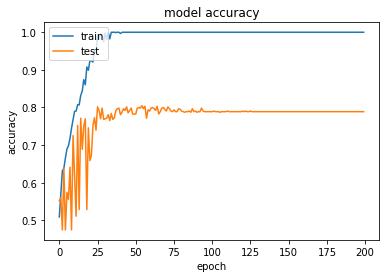

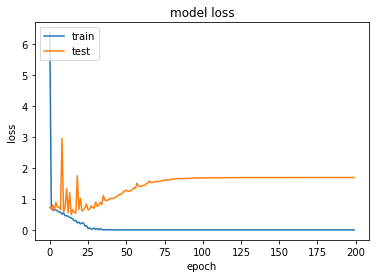

In [178]:
show_summary_stats(history)

In [179]:
from sklearn.metrics import classification_report

y_true = np.argmax(Y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1]
target_names = dict_class.keys()

print(y_true.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(630,)
                precision    recall  f1-score   support

Not Parkinsons       0.78      0.77      0.77       297
    Parkinsons       0.80      0.80      0.80       333

      accuracy                           0.79       630
     macro avg       0.79      0.79      0.79       630
  weighted avg       0.79      0.79      0.79       630



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

In [50]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [ ]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()
